In [1]:
import time
import argparse
from tqdm import tqdm

import pandas as pd

import torch
from torch.utils.data import DataLoader
import models
from torchvision.transforms import *

from transforms import *

from utils import rlenc, rlenc_np, FasterRle, gzip_save

# using opencv-python
import cv2
# use the following for resize
import skimage.transform

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

In [3]:
# SEAM dimension of raw image volume and order (y, x, z) with z fastest
ny = 1001; nx = 876; nz = 751;

# middle y
iy0 = ny//2

image shape: (1001, 876, 751), volume shape: (1001, 876, 751)


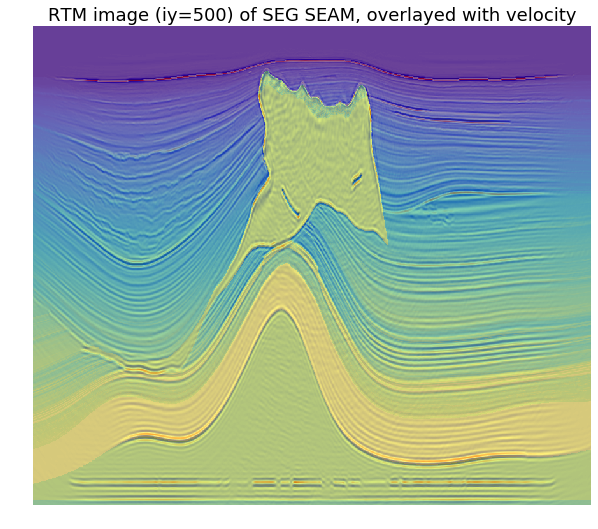

In [63]:
# image
img_name = 'dataset_seam/Img.H@'
img = np.fromfile(img_name, dtype=np.float32).reshape(ny, nx, nz)

# velocity
vol_name = 'dataset_seam/Vo.H@'
vol = np.fromfile(vol_name, dtype=np.float32).reshape(ny, nx, nz)

# the shapes
print(f'image shape: {img.shape}, volume shape: {vol.shape}')

# 
plt.figure(figsize=(10, 10))
plt.imshow(img[iy0, :, :].transpose(1,0), cmap='seismic')
plt.imshow(vol[iy0, :, :].transpose(1,0), alpha=0.6)
plt.title(f'RTM image (iy={iy0}) of SEG SEAM, overlayed with velocity', fontsize=18)
plt.axis('off');
plt.savefig('seam_rtm_vel_y500.png')

In [16]:
from dataset_seam import SEAM

# tile size for extraction
tile_size = 101

# tile skip
tile_skip = 100

# SEAM
seam = SEAM(img_name, vol_name)

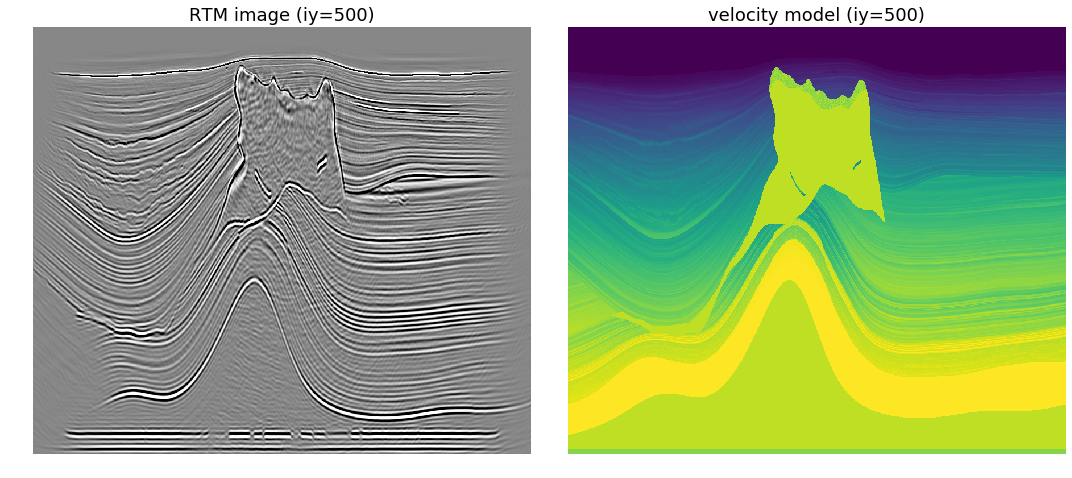

In [67]:
def draw_raw_img_mask(img, mask):
    # 
    plt.figure(figsize=(15, 8))
    #
    plt.subplot(1, 2, 1)
    plt.imshow(img.clip(70, 130), cmap='Greys')
    plt.title('RTM image (iy=500)', fontsize=18)
    plt.axis('off')
    #
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('velocity model (iy=500)', fontsize=18)
    plt.axis('off')
    #
#     plt.subplot(1, 3, 3)
#     plt.imshow(img, cmap='Greys')
#     plt.imshow(mask, alpha=0.6)
#     plt.axis('off')
    plt.tight_layout()
    plt.savefig('seam_rtm_vel_y500_2.png')

# get image
img = seam.img[iy0, :, :]
mask = seam.mask[iy0, :, :]
# convert image to between [0, 255]
img0 = 255*(img - img.min())/(img.max()-img.min())

# draw the image and mask
draw_raw_img_mask(img0, mask)

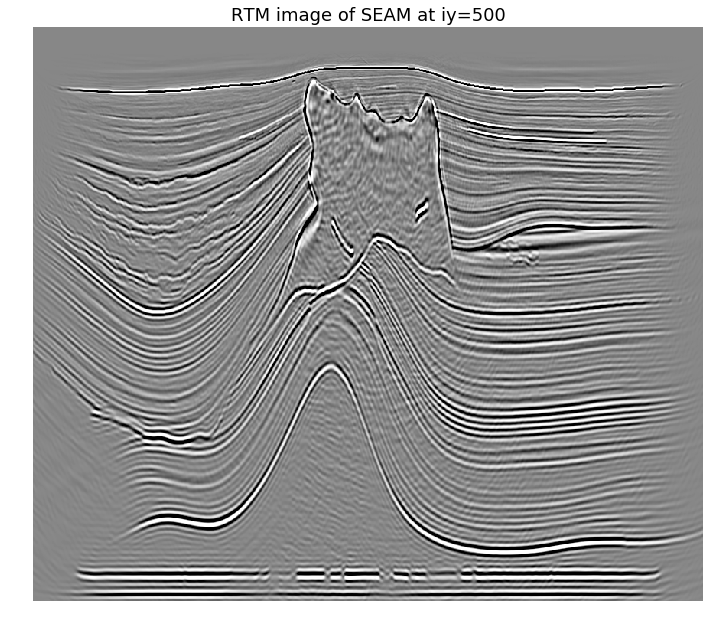

In [65]:
# rtm image
plt.figure(figsize=(12, 12))
plt.imshow(img0.clip(70, 130), cmap='Greys')
plt.title(f'RTM image of SEAM at iy={iy0}', fontsize=18)
plt.axis('off');
plt.savefig('seam_rtm_y_500.png')

total tiles: 456300
image shape: (101, 101, 3), tile id: 40_390_0, img min/max: (0, 255)
mask shape: (101, 101, 1), mask min/max: (0, 1)


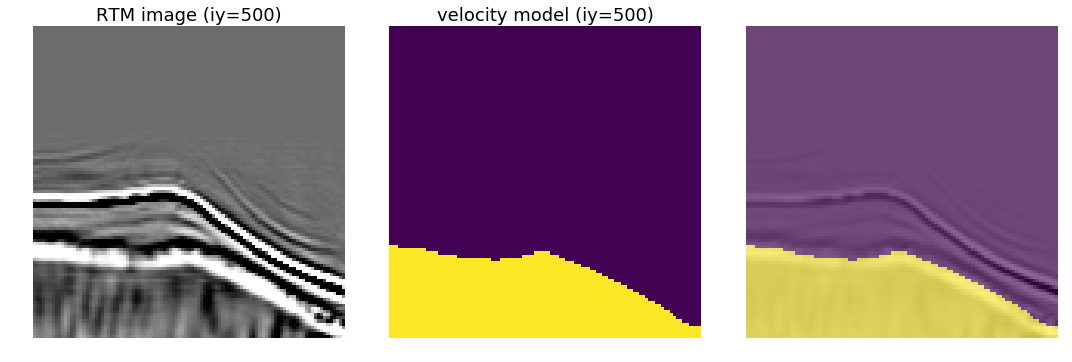

In [68]:
def draw_tile_img_mask(img, mask):
    # 
    plt.figure(figsize=(15, 8))
    #
    plt.subplot(1, 3, 1)
    plt.imshow(img.clip(70, 130), cmap='Greys')
    plt.title('RTM image (iy=500)', fontsize=18)
    plt.axis('off')
    #
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title('velocity model (iy=500)', fontsize=18)
    plt.axis('off')
    #
    plt.subplot(1, 3, 3)
    plt.imshow(img, cmap='Greys')
    plt.imshow(mask, alpha=0.6)
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('seam_tile_rtm_mask_y500.png')

#
total_tiles = len(seam)
print('total tiles: {}'.format(total_tiles))

# the tile
tile_index = total_tiles//20
tile = seam[tile_index]

tile_id = tile['image_id']
tile_img = tile['input']

print(f'image shape: {tile_img.shape}, tile id: {tile_id}, img min/max: {tile_img.min(), tile_img.max()}')

tile_mask = tile['mask']
print(f'mask shape: {tile_mask.shape}, mask min/max: {tile_mask.min(), tile_mask.max()}')

#
draw_tile_img_mask(tile_img[..., 0], tile_mask[..., 0])

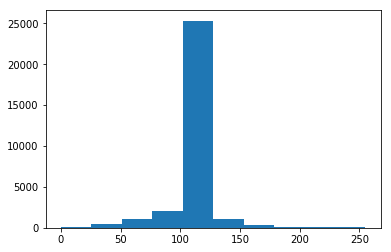

In [8]:
bin_counts, bin_edges, patches = plt.hist(tile_img.ravel())

In [9]:
orig_img_size = 101
img_size = 128
padding = compute_padding(orig_img_size, orig_img_size, img_size)
d_y0, d_y1, d_x0, d_x1 = padding
y0, y1, x0, x1 = d_y0, d_y0 + orig_img_size, d_x0, d_x0 + orig_img_size

In [10]:
y0, y1, x0, x1

(13, 114, 13, 114)

In [11]:
def predict(args, model, batch, flipped_batch, use_gpu):
    
    image_ids, inputs = batch['image_id'], batch['input']
    if use_gpu:
        inputs = inputs.cuda()
        
    # predict original data
    outputs, _, _ = model(inputs)
    probs = torch.sigmoid(outputs)

    if flipped_batch is not None:
        flipped_image_ids, flipped_inputs = flipped_batch['image_id'], flipped_batch['input']

        assert image_ids == flipped_image_ids

        if use_gpu:
            flipped_inputs = flipped_inputs.cuda()
            
        # predict flipped data
        flipped_outputs, _, _ = model(flipped_inputs)
        flipped_probs = torch.sigmoid(flipped_outputs)

        probs += torch.flip(flipped_probs, (3,))  # flip back and add
        probs *= 0.5

    probs = probs.squeeze(1).cpu().numpy()    # squeeze channel dimension
    if args.resize:
        probs = np.swapaxes(probs, 0, 2)

        probs = cv2.resize(probs, (orig_img_size, orig_img_size), interpolation=cv2.INTER_LINEAR)
#         probs = skimage.transform.resize(probs, (orig_img_size, orig_img_size) )

        probs = np.swapaxes(probs, 0, 2)
    else:
        probs = probs[:, y0:y1, x0:x1]

    return probs

In [18]:
from dataset_seam import TileBase

class Tile_mid_y(TileBase):
    """ geneate # of indices from the middle y"""
    def __init__(self, tile_size=101, tile_skip=10):
        super().__init__(tile_size, tile_skip)
        
    def generate_tile_tuples(self, nx, ny, nz):
        """ generate tiles """
        tuples = []

        for ix in range(0, nx-tile_size, tile_skip):
            for iz in range(0, nz-tile_size, tile_skip):
                tuples.append((iy0, ix, iz))

        self.indices = tuples
        self.num_items = len(tuples)

def get_random_indices(total_nums, num_items):
    """ randomly pick nums of indices from the total """
    # skip severals
    num_tries = 5
    for i in range(num_tries):
        np.random.choice(total_nums, num_items)

    # now starts to pick
    indices = np.random.choice(total_nums, num_items)

    return indices

In [19]:
def qc_test(args):
    """ for testing a small dataset """

    # test dataset
    test_transform = Compose([PrepareImageAndMask(),
                              ResizeToNxN(img_size) if args.resize else PadToNxN(img_size), HWCtoCHW()])
    # test dataset
    test_dataset = SEAM(img_name, vol_name, tile=Tile_mid_y(), transform=test_transform)
    
    # get minimum of the given batch size and the total data
    num_items = min(len(test_dataset), args.batch_size)
    #num_items = len(test_dataset)
    
    # ------ pick random indices
    #indices = range(num_items)
    indices = range(15, 15+num_items)
    print(f'indices: {list(indices)}')
    
    # get a subset of test dataset
    test_dataset0 = torch.utils.data.Subset(test_dataset, indices)
    
    test_dataloader = DataLoader(test_dataset0, batch_size=num_items, num_workers=args.dataload_workers_nums)
    test_dataloader_iter = iter(test_dataloader)

    # flipped test dataset
    flipped_test_transform = Compose([PrepareImageAndMask(), HorizontalFlip(),
                                      ResizeToNxN(img_size) if args.resize else PadToNxN(img_size), HWCtoCHW()])
    flipped_test_dataset = SEAM(img_name, tile=Tile_mid_y(), transform=flipped_test_transform)
    
    # for flipped test dataset
    flipped_test_dataset0 = torch.utils.data.Subset(flipped_test_dataset, indices)
    
    flipped_test_dataloader_iter = iter(DataLoader(flipped_test_dataset0, batch_size=num_items,
                                                   num_workers=args.dataload_workers_nums))

    model.eval()
    torch.set_grad_enabled(False)
    
    # test data
    batch = next(test_dataloader_iter)

    # flipped data
    if args.tta:
        flipped_batch = next(flipped_test_dataloader_iter)
    else:
        flipped_batch = None

    #
    image_ids = batch['image_id']
    images = batch['input']
    masks = batch['mask']
    flipped_images = flipped_batch['input']

    print(f' image shape: {images.shape}, mask shape: {masks.shape}')
    
    # predicted probabilities
    probs = predict(args, model, batch, flipped_batch, use_gpu=use_gpu)

    # prediction
    pred = np.zeros_like(probs)
    pred[probs > args.threshold] = 1

    # output probabilities
    probs_uint16 = (65535 * probs).astype(dtype=np.uint16)

    # input images
    image_samples = images[:, :, y0:y1, x0:x1].permute(0, 2, 3, 1).numpy()
    # gt mask
    mask_samples = masks[:, y0:y1, x0:x1].numpy()
    # flipped images
    flipped_image_samples = flipped_images[:, :, y0:y1, x0:x1].permute(0, 2, 3, 1).numpy()
        
    return image_ids, pred, probs_uint16, image_samples, mask_samples, flipped_image_samples

In [20]:
parser = argparse.ArgumentParser(description=__doc__, formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument("--batch-size", type=int, default=30, help='batch size')
parser.add_argument("--dataload-workers-nums", type=int, default=8, help='number of workers for dataloader')
parser.add_argument('--tta', action='store_true', help='test time augmentation')
parser.add_argument('--seed', type=int, default=None, help='manual seed for deterministic')
parser.add_argument("--threshold", type=float, default=0.5, help='probability threshold')
parser.add_argument("--output-prefix", type=str, default='noprefix', help='prefix string for output files')
parser.add_argument('--resize', action='store_true', help='resize to 128x128 instead of reflective padding')
parser.add_argument("model", help='a pretrained neural network model')

# args examples
arg_commands = '--tta my_runs/models/best-metric-model-fold0.pth --output-prefix fold0'
args = parser.parse_args(arg_commands.split())
print(vars(args))

# execute the codes
use_gpu = torch.cuda.is_available()
print('use_gpu', use_gpu)

print("loading model...")
model = models.load(args.model)
model.float()

if use_gpu:
    if args.seed is not None:
        torch.manual_seed(args.seed)
        torch.backends.cudnn.deterministic = True
    else:
        torch.backends.cudnn.benchmark = True
    model.cuda()

{'batch_size': 30, 'dataload_workers_nums': 8, 'tta': True, 'seed': None, 'threshold': 0.5, 'output_prefix': 'fold0', 'resize': False, 'model': 'my_runs/models/best-metric-model-fold0.pth'}
use_gpu True
loading model...
load my_runs/models/best-metric-model-fold0.pth


In [21]:
print("testing %s..." % args.model)
start = time.time()
# the whole dataset
#test(args)
# show only a batch
image_ids, pred, probs_uint16, image_samples, mask_samples, flipped_image_samples = qc_test(args)
time_elapsed = time.time() - start
time_str = 'total time elapsed: {:.0f}h {:.0f}m {:.0f}s '.format(time_elapsed // 3600,
                                                                 time_elapsed % 3600 // 60,
                                                                 time_elapsed % 60)
print(time_str)
print("finished")

testing my_runs/models/best-metric-model-fold0.pth...
indices: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
 image shape: torch.Size([30, 3, 128, 128]), mask shape: torch.Size([30, 128, 128])
total time elapsed: 0h 0m 13s 
finished


In [22]:
print(pred.shape, probs_uint16.shape, image_samples.shape)
print(pred.min(), pred.max())

(30, 101, 101) (30, 101, 101) (30, 101, 101, 3)
0.0 1.0


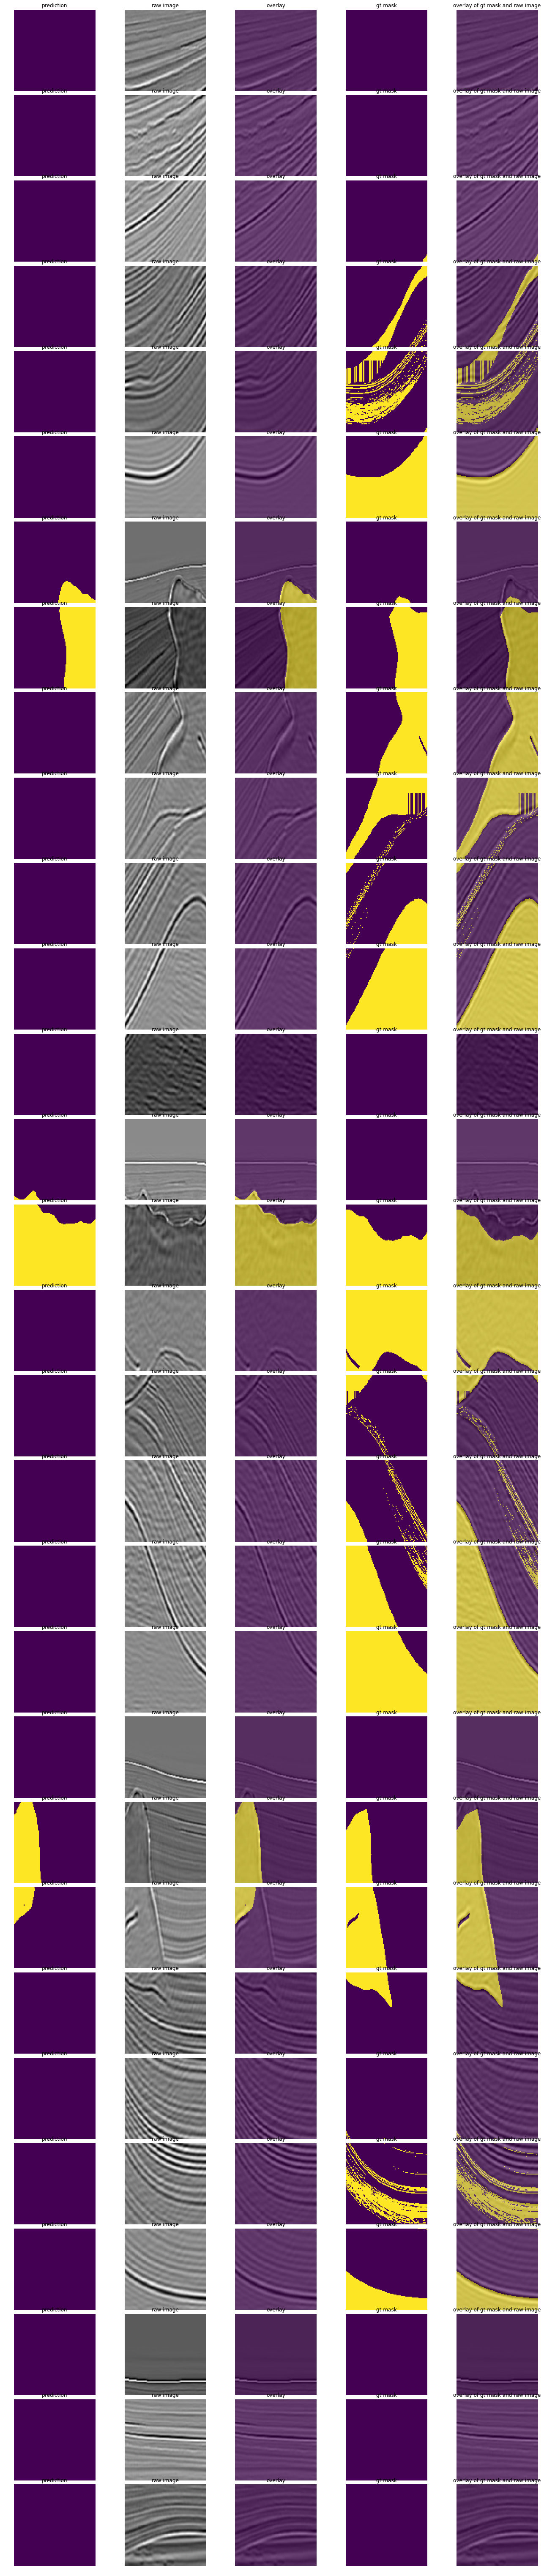

In [23]:
# qc the results
nrows = pred.shape[0]
ncols = 5

plt.figure(figsize=(18, 3.5*nrows))

for i in range(nrows):
    # predicted result
    plt.subplot(nrows, ncols, i*ncols+1)
    plt.imshow(pred[i])
    plt.title('prediction')
    # 
    plt.axis('off')
    
    # raw image
    plt.subplot(nrows, ncols, i*ncols+2)
    plt.imshow(image_samples[i], cmap='Greys')
    plt.title('raw image')
    # 
    plt.axis('off')
    
    # overlay
    plt.subplot(nrows, ncols, i*ncols+3)
    plt.imshow(pred[i])
    plt.imshow(image_samples[i], alpha=0.4, cmap='Greys')
    plt.title('overlay')
    plt.axis('off')
    
    # ground truth
    plt.subplot(nrows, ncols, i*ncols+4)
    plt.imshow(mask_samples[i])
    plt.title('gt mask')
    plt.axis('off')
    
    #
    plt.subplot(nrows, ncols, i*ncols+5)
    #plt.imshow(flipped_image_samples[i], cmap='Greys')
    #plt.title('flipped raw image')
    plt.imshow(mask_samples[i])
    plt.imshow(image_samples[i], alpha=0.4, cmap='Greys')
    plt.title('overlay of gt mask and raw image')
    plt.axis('off')

# plt.tight_layout()
plt.subplots_adjust(top=0.8, bottom=0.0, 
                    left=0.0, right=1.0, 
                    hspace=0.05, wspace=0.05)